# ML in drug research

## Data parsing [task 1]
Спарсим данные по всем молекулам из chembl таргетом для которых является cox-2. Также проведем их первичную обработку.

#### Parsing activities

Отбираем важные фичи из chembl api и собираем данные по acitivities

In [ ]:
important_fields = [
 'activity_id',
 'assay_chembl_id',
 'bao_endpoint',
 'bao_format',
 'bao_label',
 'canonical_smiles',
 'molecule_chembl_id',
 'parent_molecule_chembl_id',
 'pchembl_value',
 'potential_duplicate',
 'relation',
 'standard_flag',
 'standard_relation',
 'standard_text_value',
 'standard_type',
 'standard_units',
 'standard_upper_value',
 'standard_value',
 'target_chembl_id',
 'target_organism',
 'target_pref_name',
 'target_tax_id',
]

In [ ]:
!mkdir /content/logs

In [ ]:
import logging
logging.basicConfig(
    filename="/content/logs/activities_chembl_parse.log",
    level=logging.INFO,
    force = True,
    format="%(asctime)s [%(levelname)s] %(message)s"
)

In [ ]:
import requests
import time
from pprint import pprint
from random import uniform


headers = {'Accept': 'application/json'}
target_id = "CHEMBL230"
limit = 100



def extract_features(activities):
  extract = lambda x: {key:x[key] for key in important_fields}
  objs = []
  for act in activities:
    objs.append(extract(act))
  return objs


def parse_activities_data(target_id, limit, headers):
  rows = []
  offset = 0
  logging.info('...Start...')
  while True:
    try:
      url = f'https://www.ebi.ac.uk/chembl/api/data/activity?target_chembl_id={target_id}&limit={limit}&offset={offset}'
      req = requests.get(url, headers=headers)
      if not req.json()['activities']:
        break
      rows.extend(extract_features(req.json()['activities']))
      logging.info(f'parsed {len(rows)} objects')
      offset += limit
    except Exception as ex:
      logging.info(f'parsing error: request code - {req.status_code}, exception: {ex.message}')

  return rows

rows = parse_activities_data(target_id, limit, headers)

Данные скачались - мы получили 14150 записей

In [ ]:
len(rows)

14150

In [ ]:
!mkdir drive/MyDrive/datacon2025

Сохраняем их в отдельный файл, чтобы в следующий раз не скачивать заново.

In [ ]:
import json

json.dump(
    obj = rows,
    fp = open('drive/MyDrive/datacon2025/activities_jsons_raw.json', 'w')
)

#### Creating Dataframe

Переносим наши данные в формат датафрейма

In [ ]:
df_dict = {key: [] for key in rows[0].keys()}
for obj in rows:
  for key in df_dict.keys():
    df_dict[key].append(obj[key])

In [ ]:
import pandas as pd

In [ ]:

df = pd.DataFrame(df_dict)

In [ ]:
df.head()

,activity_id,assay_chembl_id,bao_endpoint,bao_format,bao_label,canonical_smiles,molecule_chembl_id,parent_molecule_chembl_id,pchembl_value,potential_duplicate,...,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id
0,34205,CHEMBL762912,BAO_0000190,BAO_0000357,single protein format,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,CHEMBL297008,CHEMBL297008,7.22,0,...,=,None,IC50,nM,None,60.0,CHEMBL230,Homo sapiens,Cyclooxygenase-2,9606
1,34209,CHEMBL762912,BAO_0000190,BAO_0000357,single protein format,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,CHEMBL289813,CHEMBL289813,5.49,0,...,=,None,IC50,nM,None,3230.0,CHEMBL230,Homo sapiens,Cyclooxygenase-2,9606
2,35476,CHEMBL762912,BAO_0000190,BAO_0000357,single protein format,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,CHEMBL43736,CHEMBL43736,7.10,0,...,=,None,IC50,nM,None,80.0,CHEMBL230,Homo sapiens,Cyclooxygenase-2,9606
3,36218,CHEMBL769655,BAO_0000190,BAO_0000357,single protein format,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,CHEMBL140167,CHEMBL140167,9.92,0,...,=,None,IC50,nM,None,0.12,CHEMBL230,Homo sapiens,Cyclooxygenase-2,9606
4,36708,CHEMBL762912,BAO_0000190,BAO_0000357,single protein format,CCc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,CHEMBL44194,CHEMBL44194,None,0,...,>,None,IC50,nM,None,100000.0,CHEMBL230,Homo sapiens,Cyclooxygenase-2,9606


И сохраняем его тоже

In [ ]:
df.to_csv('drive/MyDrive/datacon2025/activities_dataframe.csv')

In [ ]:
df = pd.read_csv('drive/MyDrive/datacon2025/activities_dataframe.csv', index_col=0)

Мы видим что среди 14к записей уникальными являются лишь ~8600 молекул. Учтем это в дальнейшей обработке.

In [ ]:
len(df['molecule_chembl_id'].unique())

8694

#### Preprocessing

Оставим только те записи, для которых stadard_type равен ic50

In [ ]:
ic50_df = df[df['standard_type'] == 'IC50']
ic50_df.shape

(7979, 22)

In [ ]:
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'bao_endpoint', 'bao_format',
       'bao_label', 'canonical_smiles', 'molecule_chembl_id',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'relation', 'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id'],
      dtype='object')

Колонка target_organism не несет никакой информации - можно дропать

In [ ]:
ic50_df['target_organism'].value_counts()

,count
target_organism,
Homo sapiens,7979


In [ ]:
ic50_df = ic50_df.drop(['target_organism'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'bao_endpoint', 'bao_format',
       'bao_label', 'canonical_smiles', 'molecule_chembl_id',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'relation', 'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_pref_name',
       'target_tax_id'],
      dtype='object')

Тоже самое касается признаков вида target_

In [ ]:
ic50_df['target_chembl_id'].value_counts()

,count
target_chembl_id,
CHEMBL230,7979


In [ ]:
ic50_df = ic50_df.drop(['target_chembl_id', 'target_pref_name', 'target_tax_id'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'bao_endpoint', 'bao_format',
       'bao_label', 'canonical_smiles', 'molecule_chembl_id',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'relation', 'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value'],
      dtype='object')

Из всех измерений будем оставлять только те записи, в которых значение измерения является точным числом, а не порогом.

In [ ]:
ic50_df['standard_relation'].value_counts()

,count
standard_relation,
=,5948
>,973
<,56
>=,1


In [ ]:
ic50_df = ic50_df[ic50_df['standard_relation'] == '=']
ic50_df.shape

(5948, 18)

Выкидываем колонки связанные с типом измерения

In [ ]:
ic50_df = ic50_df.drop(['relation', 'standard_relation'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'bao_endpoint', 'bao_format',
       'bao_label', 'canonical_smiles', 'molecule_chembl_id',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'standard_flag', 'standard_text_value', 'standard_type',
       'standard_units', 'standard_upper_value', 'standard_value'],
      dtype='object')

In [ ]:
ic50_df.shape

(5948, 16)

Видим, что у нас в данных есть разные форматы исследований. Для того, чтобы датасет был более репрезентативным - оставим только лишь наиболее многочисленный тип эксперимента - single protein format

In [ ]:
ic50_df['bao_label'].value_counts()

,count
bao_label,
single protein format,4545
cell-based format,694
tissue-based format,553
assay format,145
organism-based format,11


In [ ]:
ic50_df = ic50_df[ic50_df['bao_label'] == 'single protein format']
ic50_df.shape

(4545, 16)

In [ ]:
ic50_df['bao_endpoint'].value_counts(),ic50_df['bao_format'].value_counts()

(bao_endpoint
 BAO_0000190    4545
 Name: count, dtype: int64,
 bao_format
 BAO_0000357    4545
 Name: count, dtype: int64)

Теперь и все колонки типа bao можно выкинуть

In [ ]:
ic50_df = ic50_df.drop(['bao_label', 'bao_format', 'bao_endpoint'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'canonical_smiles',
       'molecule_chembl_id', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'standard_flag', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value'],
      dtype='object')

In [ ]:
ic50_df.shape

(4545, 13)

Почти все оставшиеся записи имеют единецей измерения ic50 nM. Есть 17 записей в ug.mL-1 и еще по одной записи других единиц измерения. Последние два варианта мы просто отбросим - так как это всего две записи. А 17 конвертируем в nM

In [ ]:
ic50_df['standard_units'].value_counts()

,count
standard_units,
nM,4526
ug.mL-1,17
ug,1
%,1


In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 52.5 MB/s eta 0:00:00


Преобразуем все объекты с ug.mL-1 в nM

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def convert_to_nM(smiles, value):
  mol = Chem.MolFromSmiles(smiles)
  mol_weight = Descriptors.MolWt(mol)
  nM = (value * 1e-3 / mol_weight) * 1e9
  return nM

converted_values = ic50_df.apply(lambda x: convert_to_nM(x['canonical_smiles'],float(x['standard_value'])) if x['standard_units'] == 'ug.mL-1' else float(x['standard_value']), axis = 1)


In [ ]:
ic50_df['converted_values'] = converted_values
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'canonical_smiles',
       'molecule_chembl_id', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'standard_flag', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'converted_values'],
      dtype='object')

In [ ]:
ic50_df.shape

(4545, 14)

Выкидываем два объекта с не релевантными единицами измерения

In [ ]:
ic50_df = ic50_df[(ic50_df['standard_units'] == 'ug.mL-1') | (ic50_df['standard_units']== 'nM')]

In [ ]:
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'canonical_smiles',
       'molecule_chembl_id', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'standard_flag', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'converted_values'],
      dtype='object')

In [ ]:
ic50_df.head()

,activity_id,assay_chembl_id,canonical_smiles,molecule_chembl_id,parent_molecule_chembl_id,pchembl_value,potential_duplicate,standard_flag,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,converted_values
0,34205,CHEMBL762912,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,CHEMBL297008,CHEMBL297008,7.22,0,1,NaN,IC50,nM,NaN,60.00,60.00
1,34209,CHEMBL762912,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,CHEMBL289813,CHEMBL289813,5.49,0,1,NaN,IC50,nM,NaN,3230.00,3230.00
2,35476,CHEMBL762912,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,CHEMBL43736,CHEMBL43736,7.10,0,1,NaN,IC50,nM,NaN,80.00,80.00
3,36218,CHEMBL769655,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,CHEMBL140167,CHEMBL140167,9.92,0,1,NaN,IC50,nM,NaN,0.12,0.12
5,39073,CHEMBL762912,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,CHEMBL44290,CHEMBL44290,5.79,0,1,NaN,IC50,nM,NaN,1610.00,1610.00


In [ ]:
ic50_df['standard_flag'].value_counts()

,count
standard_flag,
1,4543


In [ ]:
ic50_df['standard_text_value'].value_counts()

,count
standard_text_value,


In [ ]:
ic50_df['standard_upper_value'].value_counts()

,count
standard_upper_value,


Все эти колонки не несут смысла (как видно из строчек выше) - поэтому их также выкидываем

In [ ]:
ic50_df = ic50_df.drop(['standard_upper_value', 'standard_text_value', 'standard_flag'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'canonical_smiles',
       'molecule_chembl_id', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'standard_type', 'standard_units',
       'standard_value', 'converted_values'],
      dtype='object')

Видим, что среди оставшихся записей есть дубликаты молекул. Учитывая, что разные эксперименты, проведенные в разных условиях могут колебаться в своих результатах, кажется, что самым верным вариантом будет взять медиану целевой величины - ic50

In [ ]:
ic50_df['molecule_chembl_id'].value_counts()

,count
molecule_chembl_id,
CHEMBL118,167
CHEMBL6,87
CHEMBL521,30
CHEMBL122,24
CHEMBL7162,21
...,...
CHEMBL213338,1
CHEMBL404107,1
CHEMBL254377,1


<Axes: >

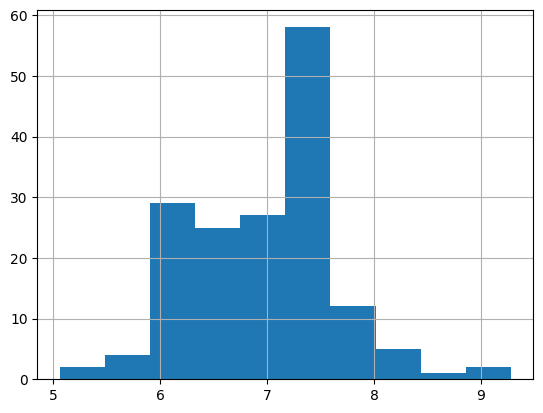

In [ ]:
ic50_df[ic50_df['molecule_chembl_id'] == 'CHEMBL118']['pchembl_value'].hist()

Аргерируем повторяющиеся молекулы

In [ ]:
final_df = ic50_df.groupby('molecule_chembl_id').agg({
    'canonical_smiles': 'first',
    'converted_values': 'median',
    'pchembl_value': 'median'
})

final_df

,canonical_smiles,converted_values,pchembl_value
molecule_chembl_id,,,
CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,60.0,7.22
CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,60.0,7.22
CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,4000.0,5.40
CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,4000.0,5.40
CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,40.0,7.40
...,...,...,...
CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,4000.0,5.40
CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,13000.0,4.89
CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,130000.0,NaN


Теперь логарифмируем и приведем к более приятному виду значения standard value

In [ ]:
import numpy as np

def pchembl_from_nM(nM_value):
    molar = nM_value * 1e-9
    return -np.log10(molar)

Выкидываем нулевые значения

In [ ]:
final_df = final_df[final_df['converted_values'] != 0]

In [ ]:
final_df['log_ic50(pchembl)'] = pchembl_from_nM(final_df['converted_values'])
final_df

/tmp/ipython-input-82-1061664099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['log_ic50(pchembl)'] = pchembl_from_nM(final_df['converted_values'])


,canonical_smiles,converted_values,pchembl_value,log_ic50(pchembl)
molecule_chembl_id,,,,
CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,60.0,7.22,7.221849
CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,60.0,7.22,7.221849
CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,4000.0,5.40,5.397940
CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,4000.0,5.40,5.397940
CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,40.0,7.40,7.397940
...,...,...,...,...
CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,4000.0,5.40,5.397940
CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,13000.0,4.89,4.886057
CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,130000.0,NaN,3.886057


In [ ]:
final_df = final_df.reset_index()

In [ ]:
final_df = final_df.drop(['converted_values', 'pchembl_value'], axis = 1)
final_df

,molecule_chembl_id,canonical_smiles,log_ic50(pchembl)
0,CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,7.221849
1,CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,7.221849
2,CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,5.397940
3,CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,5.397940
4,CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,7.397940
...,...,...,...
3385,CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,5.397940
3386,CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,4.886057
3387,CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,3.886057
3388,CHEMBL99828,Cc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(F)cc2)s1,5.000000


Финальный шаг - проверим валидность smiles

In [ ]:
from rdkit import Chem

def is_valid_smiles(smiles):
    if pd.isna(smiles):
        return False
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

final_df["canonical_smiles"].apply(is_valid_smiles).sum() == final_df.shape[0]

np.True_

In [ ]:
final_df

,molecule_chembl_id,canonical_smiles,log_ic50(pchembl)
0,CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,7.221849
1,CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,7.221849
2,CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,5.397940
3,CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,5.397940
4,CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,7.397940
...,...,...,...
3385,CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,5.397940
3386,CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,4.886057
3387,CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,3.886057
3388,CHEMBL99828,Cc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(F)cc2)s1,5.000000


Сохраняем полученные данные

In [ ]:
final_df.to_csv('/content/drive/MyDrive/datacon2025/final_df_task1.csv')

## Descriptors (feature extraction) [task 2]

---



#### RDkit

In [ ]:
!pip install rdkit

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm.notebook import tqdm

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/datacon2025/final_df_task1.csv', index_col = 0)
final_df

,molecule_chembl_id,canonical_smiles,log_ic50(pchembl)
0,CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,7.221849
1,CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,7.221849
2,CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,5.397940
3,CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,5.397940
4,CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,7.397940
...,...,...,...
3385,CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,5.397940
3386,CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,4.886057
3387,CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,3.886057
3388,CHEMBL99828,Cc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(F)cc2)s1,5.000000


Создадим таблицу значений всех дескрипторов из rdkit

In [ ]:
descriptor_list = Descriptors.descList
print(f"Всего дескрипторов: {len(descriptor_list)}")

descriptor_names = [name for name, func in descriptor_list]

def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    values = []
    for name, func in descriptor_list:
        try:
            val = func(mol)
        except:
            val = None
        values.append(val)
    return values

desc_values = final_df["canonical_smiles"].apply(calc_descriptors)
desc_df = pd.DataFrame(desc_values.tolist(), columns=descriptor_names)
desc_df

Всего дескрипторов: 217


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.299115,13.299115,0.046983,-0.367590,0.308874,11.000000,457.954,429.730,457.165601,170,...,0,0,0,0,0,0,0,0,1,0
1,13.290871,13.290871,0.101366,-0.291287,0.303112,10.967742,441.955,413.731,441.170686,164,...,0,0,0,0,0,0,0,0,3,0
2,11.521156,11.521156,0.349760,-3.148077,0.713775,11.476190,314.431,300.319,314.043522,106,...,0,0,1,0,0,0,0,1,0,0
3,11.521156,11.521156,0.349760,-3.148077,0.713775,11.476190,314.431,300.319,314.043522,106,...,0,0,1,0,0,0,0,1,0,0
4,13.353022,13.353022,0.034750,-0.154564,0.334799,11.030303,469.025,435.761,468.217971,176,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,11.553057,11.553057,0.350338,-3.152845,0.692258,11.545455,328.458,312.330,328.059172,112,...,0,0,1,0,0,0,0,1,0,0
3386,11.553057,11.553057,0.350338,-3.152845,0.692258,11.545455,328.458,312.330,328.059172,112,...,0,0,1,0,0,0,0,1,0,0
3387,13.364568,13.364568,0.246956,-3.277701,0.486331,11.413793,432.538,411.370,432.086529,152,...,0,0,1,0,0,0,0,1,0,0
3388,13.133786,13.133786,0.262886,-3.202678,0.673488,11.608696,346.448,331.328,346.049750,118,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
desc_df.to_csv('/content/drive/MyDrive/datacon2025/rdkit_descriptors.csv')

Выделим фичи, в которых есть пропуски

In [ ]:
nans = desc_df.isna().sum().to_dict()
nan_features = []
for key in nans:
  if nans[key] >0:
    nan_features.append(key)

nan_features

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

Заполняем пропуски медианными значениями

In [ ]:
df_desc_filled = desc_df.fillna(desc_df.median())
(df_desc_filled.isna().sum() > 0).sum()

0

Удаляем колонки с нулевой дисперсией

In [ ]:
zero_var_cols = [c for c in df_desc_filled.columns if df_desc_filled[c].nunique() <= 1]
zero_var_cols

['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 'fr_benzodiazepine',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_phos_acid',
 'fr_phos_ester',
 'fr_prisulfonamd',
 'fr_quatN']

In [ ]:
df_desc_filled = df_desc_filled.drop(zero_var_cols, axis = 1)
len(df_desc_filled.columns)

204

Из признаков с взаимной корреляцией больше 0.7 удаляем один

In [ ]:
import numpy as np

corr_matrix = df_desc_filled.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper.columns if any(upper[column] > 0.7)
]

to_drop

['MaxEStateIndex',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'SMR_VSA1',
 'SMR_VSA5',
 'SMR_VSA7',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'TPSA',
 'EState_VSA1',
 'EState_VSA10',
 'VSA_EState1',
 'VSA_EState10',
 'VSA_EState3',
 'VSA_EState6',
 'VSA_EState7',
 'VSA_EState9',
 'FractionCSP3',
 'HeavyAtomCount',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumAtomStereoCenters',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 '

In [ ]:
df_desc_filled = df_desc_filled.drop(to_drop, axis = 1)
len(df_desc_filled.columns)

114

Сохраняем дескрипторы для rdkit

In [ ]:
df_desc_filled.to_csv('/content/drive/MyDrive/datacon2025/prerared_rdkit_descriptors.csv')

#### Mordred

In [ ]:
!pip install mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.7 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=6f85773e7c753d95e7beb5f59329483a935e87048a669ab8ab280767d476fcf1
  Stored in directory: /root/.cache/pip/wheels/8b/30/0b/84e3f6775306e74cf5957ee4d16b10bf3927dcec44cc23d5f2
Successfully built mordred
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: networkx
    Found existing installation: networkx 3.5
    Uninstalling networkx-3.5:
      Successfully uninstalled networkx-3.5
ERROR: pip's dependency resolver does not currently t

In [ ]:
import pandas as pd
from rdkit import Chem
from mordred import Calculator, descriptors
from tqdm import tqdm

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/datacon2025/final_df_task1.csv', index_col = 0)
final_df

,molecule_chembl_id,canonical_smiles,log_ic50(pchembl)
0,CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,7.221849
1,CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,7.221849
2,CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,5.397940
3,CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,5.397940
4,CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,7.397940
...,...,...,...
3385,CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,5.397940
3386,CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,4.886057
3387,CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,3.886057
3388,CHEMBL99828,Cc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(F)cc2)s1,5.000000


Также берем вытаскиваем значения всех дескрипторов из mordred

In [ ]:
calc = Calculator(descriptors, ignore_3D=True)


def calc_mordred(smiles):
    mol = Chem.MolFromSmiles(smiles)
    try:
        return calc(mol)
    except:
        return None

# Оборачиваем в tqdm
mordred_results = []
for smiles in tqdm(final_df["canonical_smiles"], desc="Calculating descriptors"):
    res = calc_mordred(smiles)
    mordred_results.append(res)

mordred_dicts = [r.asdict() if r is not None else {} for r in mordred_results]
mordred_df = pd.DataFrame(mordred_dicts)

Calculating descriptors:   2%|▏         | 81/3390 [00:16<09:56,  5.55it/s]/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Calculating descriptors: 100%|██████████| 3390/3390 [15:07<00:00,  3.74it/s]


In [ ]:
mordred_df.shape

(3390, 1613)

In [ ]:
mordred_df.to_csv('/content/drive/MyDrive/datacon2025/mordred_descriptors_raw.csv')

In [ ]:
mordred_df.shape

(3390, 1613)

Пустых значений нет

In [ ]:
mordred_df.isnull().sum().sum()

0

Удаляем признаки с нулевой дисперсией

In [ ]:
zero_var_cols = [c for c in mordred_df.columns if mordred_df[c].nunique() <= 1]
zero_var_cols

['NsLi',
 'NssBe',
 'NssssBe',
 'NssBH',
 'NsssB',
 'NssssB',
 'NddC',
 'NsNH3',
 'NssNH2',
 'NsssNH',
 'NssssN',
 'NsSiH3',
 'NssSiH2',
 'NsssSiH',
 'NsPH2',
 'NssPH',
 'NsssP',
 'NsssssP',
 'NdssS',
 'NsGeH3',
 'NssGeH2',
 'NsssGeH',
 'NssssGe',
 'NsAsH2',
 'NssAsH',
 'NsssAs',
 'NsssdAs',
 'NsssssAs',
 'NsSeH',
 'NdSe',
 'NdssSe',
 'NddssSe',
 'NsSnH3',
 'NssSnH2',
 'NsssSnH',
 'NssssSn',
 'NsPbH3',
 'NssPbH2',
 'NsssPbH',
 'NssssPb',
 'SsLi',
 'SssBe',
 'SssssBe',
 'SssBH',
 'SsssB',
 'SssssB',
 'SddC',
 'SsNH3',
 'SssNH2',
 'SsssNH',
 'SssssN',
 'SsSiH3',
 'SssSiH2',
 'SsssSiH',
 'SsPH2',
 'SssPH',
 'SsssP',
 'SsssssP',
 'SdssS',
 'SsGeH3',
 'SssGeH2',
 'SsssGeH',
 'SssssGe',
 'SsAsH2',
 'SssAsH',
 'SsssAs',
 'SsssdAs',
 'SsssssAs',
 'SsSeH',
 'SdSe',
 'SdssSe',
 'SddssSe',
 'SsSnH3',
 'SssSnH2',
 'SsssSnH',
 'SssssSn',
 'SsPbH3',
 'SssPbH2',
 'SsssPbH',
 'SssssPb',
 'SMR_VSA8',
 'SlogP_VSA9',
 'n8Ring',
 'n4HRing',
 'n8HRing',
 'n9HRing',
 'n10HRing',
 'n3aRing',
 'n4aRing',
 'n7

In [ ]:
mordred_df = mordred_df.drop(columns=zero_var_cols)

In [ ]:
mordred_df.shape

(3390, 1483)

Удаляем убираем дублирующие признаки

In [ ]:
import numpy as np

corr_matrix = mordred_df.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper.columns if any(upper[column] > .7)]
to_drop

['SpDiam_A',
 'SpAD_A',
 'LogEE_A',
 'VE1_A',
 'VE2_A',
 'VE3_A',
 'VR2_A',
 'VR3_A',
 'nAromBond',
 'nAtom',
 'nHeavyAtom',
 'nHetero',
 'nH',
 'nC',
 'nO',
 'nX',
 'ATS0dv',
 'ATS1dv',
 'ATS2dv',
 'ATS3dv',
 'ATS4dv',
 'ATS5dv',
 'ATS6dv',
 'ATS7dv',
 'ATS8dv',
 'ATS0d',
 'ATS1d',
 'ATS2d',
 'ATS3d',
 'ATS4d',
 'ATS5d',
 'ATS6d',
 'ATS7d',
 'ATS8d',
 'ATS0s',
 'ATS1s',
 'ATS2s',
 'ATS3s',
 'ATS4s',
 'ATS5s',
 'ATS6s',
 'ATS7s',
 'ATS8s',
 'ATS0Z',
 'ATS1Z',
 'ATS2Z',
 'ATS3Z',
 'ATS4Z',
 'ATS5Z',
 'ATS6Z',
 'ATS7Z',
 'ATS8Z',
 'ATS0m',
 'ATS1m',
 'ATS2m',
 'ATS3m',
 'ATS4m',
 'ATS5m',
 'ATS6m',
 'ATS7m',
 'ATS8m',
 'ATS0v',
 'ATS1v',
 'ATS2v',
 'ATS3v',
 'ATS4v',
 'ATS5v',
 'ATS6v',
 'ATS7v',
 'ATS8v',
 'ATS0se',
 'ATS1se',
 'ATS2se',
 'ATS3se',
 'ATS4se',
 'ATS5se',
 'ATS6se',
 'ATS7se',
 'ATS8se',
 'ATS0pe',
 'ATS1pe',
 'ATS2pe',
 'ATS3pe',
 'ATS4pe',
 'ATS5pe',
 'ATS6pe',
 'ATS7pe',
 'ATS8pe',
 'ATS0are',
 'ATS1are',
 'ATS2are',
 'ATS3are',
 'ATS4are',
 'ATS5are',
 'ATS6are',
 'AT

In [ ]:
len(to_drop)

1224

In [ ]:
mordred_df = mordred_df.drop(to_drop, axis = 1)
mordred_df.shape

(3390, 259)

В ходе вычисления признаков появилось много ошибок. Удалим полностью некорректные признаки и заполним медианой признаки с малым числом пропусков

In [117]:
mordred_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpMAD_A,VR1_A,nAromAtom,nSpiro,...,n9FRing,n10FRing,n11FRing,n12FRing,n8FaRing,n12FaRing,nG12FaRing,n10FARing,JGI8,JGI10
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,40.898747,2.545115,1.278086,4715.076859,15,0,...,1,0,0,0,0,0,0,0,0.011365,0.007911
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,39.469365,2.545115,1.273205,2399.084322,15,0,...,1,0,0,0,0,0,0,0,0.011005,0.008228
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,27.074024,2.43033,1.289239,128.065383,17,0,...,0,0,0,0,0,0,0,0,0.018277,0.008862
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,27.074024,2.43033,1.289239,128.065383,17,0,...,0,0,0,0,0,0,0,0,0.018277,0.008862
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,42.034289,2.545115,1.273766,9485.047291,15,0,...,1,0,0,0,0,0,0,0,0.011073,0.007346


In [75]:
temp = mordred_df.astype(float)

In [112]:
nans = temp.isna().sum().sort_values(ascending=True)
drop_cols = nans[nans > 41].index
temp = temp.drop(drop_cols, axis = 1)
temp = temp.fillna(temp.median())

In [114]:
temp.isna().sum().sum()

0

In [118]:
temp.shape

(3390, 160)

In [119]:
temp.to_csv('/content/drive/MyDrive/datacon2025/mordred_descriptors_prepared.csv')

#### Morgan fingerprints

Также создадим таблицу для morgan fingerprints

In [ ]:
from rdkit import RDLogger
from rdkit.Chem import AllChem
RDLogger.DisableLog('rdApp.warning')


def compute_morgan_fingerprints(smiles_list, n_bits=2048, radius=2):
    fps_array = []
    for smi in tqdm(smiles_list, desc="Morgan fingerprints"):
        mol = Chem.MolFromSmiles(smi)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=int)
        AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)

    fps_df = pd.DataFrame(fps_array, columns=[f"morgan_{i}" for i in range(n_bits)])

    return fps_df


morgan_fps = compute_morgan_fingerprints(
    smiles_list=final_df["canonical_smiles"],
    n_bits=2048,
    radius=2
)

Morgan fingerprints: 100%|██████████| 3390/3390 [00:02<00:00, 1663.82it/s]


In [ ]:
morgan_fps.shape

(3390, 2048)

In [ ]:
morgan_fps.head()

,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,morgan_6,morgan_7,morgan_8,morgan_9,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
base_dir = '/content/drive/MyDrive/datacon2025/'
morgan_fps.to_csv(base_dir + 'morgan_fps.csv')

#### MACSS fingerprints

Аналогично создадим macss fingerprints

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
import numpy as np
from tqdm import tqdm

def compute_maccs_fingerprints(smiles_list):
    fps_array = []

    for smi in tqdm(smiles_list, desc="MACCS fingerprints"):
        mol = Chem.MolFromSmiles(smi)
        fp = MACCSkeys.GenMACCSKeys(mol)
        arr = np.zeros((fp.GetNumBits(),), dtype=int)
        Chem.DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)

    fps_df = pd.DataFrame(fps_array, columns=[f"maccs_{i}" for i in range(167)])

    return fps_df


maccs_fps = compute_maccs_fingerprints(final_df["canonical_smiles"])

MACCS fingerprints: 100%|██████████| 3390/3390 [00:05<00:00, 634.51it/s]


In [ ]:
maccs_fps.shape

(3390, 167)

In [ ]:
maccs_fps.head()

,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,...,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [ ]:
maccs_fps.to_csv(base_dir + 'maccs_fingerprints')

## ML models
- Random Forest (for feature importance)
---- rdkit
---- mordred (make pca)
---- morgan
---- macss

-
